# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from sklearn.decomposition import PCA
from itertools import cycle
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   '

# Repeated k-Fold Cross Validation
For each model, fit it k (=10) times, and track all metrics, as well as interpretability, across all the repeats.
This gets us a less noisy estimate at our models' performance.

In [3]:
def repeated_kfold_cv(model, k = 10, seed = 19104):

    """
    Parameters:
    - model: The model we are doing k-fold CV for
    - k: the number of fols (defaults to 10)
    - seed: the random seed (defaults to 19104)

    @returns the following, pouplated with data from the k0=-fold CV:
    - train_metrics: a dataframe to store all the training metrics
    - test_metrics: a dataframe to store all the test set metrics (we will universally use a 80-20 train-test split)
    - shap_df: a dataframe to store the Shapley value summaries for each fold
    - shap_correlation_df: a dataframe to store how the Shapley values correlate with feature values for each fold
    """

    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    train_metrics = pd.DataFrame(columns=metrics)
    test_metrics = pd.DataFrame(columns=metrics)

    for i in range(len(random_states_list)):
        # store the model metrics for each iteration
        metrics = model.evaluate_model(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i], visualize_model = False)
        train_metrics = train_metrics.append(metrics['train'], ignore_index=True)
        test_metrics = test_metrics.append(metrics['val'], ignore_index=True)
    
        # store the shap summary for each iteration

        try:     
            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)
        except NameError:
            # we haven't defined these yet; we're in the first iteration!
            # we have to do this becaus model.X does not show up until after the first case when evaluate_model is called
            shap_df = pd.DataFrame({'feature': model.X.columns})
            shap_correlation_df = pd.DataFrame({'feature': model.X.columns})

            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)


    shap_df.set_index('feature', inplace=True)
    shap_correlation_df.set_index('feature', inplace=True)

    return(shap_df, shap_correlation_df, train_metrics, test_metrics)

In [4]:
def get_repeated_kfold_cv_summary(shap_df, shap_correlation_df, train_metrics, test_metrics):
    """
    Get the means of the repeated k-fold cross validation across all relevant metrics.
    """
    shap_means = shap_df.mean(axis=1).sort_values(ascending = False)
    shap_cor_means = shap_correlation_df.mean(axis=1).reindex(index = shap_means.index)
    train_means = train_metrics.mean()
    test_means = test_metrics.mean()

    return(shap_means, shap_cor_means, train_means, test_means)

In [5]:
time_points = ["25%", "50%", "75%", "100%"]

In [6]:
NUM_TOP_FEATURES = 5

In [7]:
def plot_important_features_over_time(merged_df, color_palette, title="Top Feature Importance Over Time", filename="./figures/feature_importance.png"):
    # Transpose the DataFrame and sort by each time point
    top_features = merged_df.apply(lambda x: x.nlargest(NUM_TOP_FEATURES))

    non_na_feature = top_features.dropna()
    na_feature = top_features.loc[~top_features.index.isin(top_features.dropna().index)].fillna(0)

    # Plot a line chart to show how the top feature values change over time
    if not non_na_feature.empty and not na_feature.empty:
        ax = non_na_feature.T.plot(kind='line', marker='o', linewidth=3, color=color_palette)
        na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, ax=ax, color=color_palette)  # Use the same axis for dashed lines
    elif non_na_feature.empty:
        ax = na_feature.T.plot(kind='line', marker='o', linestyle='--', linewidth=3, color=color_palette)
    elif na_feature.empty:
        ax = non_na_feature.T.plot(kind='line', marker='o', linewidth=3, color=color_palette)

    plt.ylabel('Importance (SHAP value)', size=14)
    plt.xlabel('Percent of Chat Messages (Chronological)', size=14)
    plt.title(title, fontsize=18, fontweight="bold")
    plt.xticks(range(len(time_points)), time_points, fontsize=14)

    # Update legend with custom color mapping
    legend_labels = ax.get_legend().get_texts()
    for label in legend_labels:
        feature_name = label.get_text()

    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.05, 1), bbox_transform=ax.transAxes)

    plt.savefig(filename, dpi=1200, bbox_inches='tight')
    plt.show()

In [8]:
def plot_r2_and_mse_over_time(metrics, title):
    # Transpose the data for plotting
    transposed_data = metrics.T
    fig, ax1 = plt.subplots()

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Create the left y-axis for R^2
    ax1.set_ylabel("R^2", fontsize=14)
    ax1.plot(time_points, transposed_data["r2"], label="R^2", color="cadetblue", marker="o", linewidth=3)
    ax1.tick_params(axis="y", size=14)

    # Create the right y-axis for MSE
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("MSE", fontsize=14)
    ax2.plot(time_points, transposed_data["mse"], label="MSE", color="mediumorchid", marker="o", linewidth=3)
    ax2.tick_params(axis="y", size=14)

    #x-axis font size
    ax1.tick_params(axis="x", labelsize=14)
    ax1.set_xlabel('Percent of Chat Messages (Chronological)', size=14)

    # Combine the legends for both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left")

    # Adjust layout
    plt.title(title, fontweight="bold", fontsize=18)
    plt.tight_layout()
    plt.show()

# Per-Task Baseline Models
This notebook contains the _baseline models_ for each task. This allows us to get a quick understanding of the predictive features for each task (separately).

The lists of models are:

(1) Random Forests for each task:
- Jury
- CSOP Blended (across two datasets)
- CSOP Train -> CSOP II split
- DAT
- Estimation (Becker + Gurcay datasets, blended)

(2) Early Cut-off Models (Train model only on the first X% of the messages, so that we avoid issues where the final stages of the discussion reveal the outcome)
- 25% (all datasets)
- 50% (all datasets)
- 75% (all datasets)


# Jury

### Full Data (100)%

In [20]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"], min_num_chats=10)
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

In [21]:
# Call the Repeated k-Fold CV
jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics = repeated_kfold_cv(juries_model)
jury_shap_means, jury_shap_cor_means, jury_train_means, jury_test_means = get_repeated_kfold_cv_summary(jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


In [22]:
juries_model.conv

,gini_coefficient_sum_num_words,gini_coefficient_sum_num_chars,gini_coefficient_sum_num_messages,average_positive_bert,stdev_positive_bert,min_positive_bert,max_positive_bert,average_negative_bert,stdev_negative_bert,min_negative_bert,...,Q20type_3_type_4,Q22confl_tradeoffs,Q23ss_out_uncert,Q24eureka_question,Q2intel_manip_1,Q21intellective_judg_1,Q5creativity_input_1,Q25_type6_mixed_motive,target_raw,target_std
0,-0.968071,-0.903531,-0.403874,0.646356,0.717879,0.469979,0.245807,-0.043844,0.302531,-0.539038,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
1,-1.433233,-1.470332,0.829248,-0.293294,-0.180408,-0.412163,0.290992,0.353607,0.904269,-0.112158,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.600000,-1.368196
2,-0.066840,-0.153075,1.250815,-0.796815,-1.015673,0.719373,-1.376046,1.218315,0.479345,0.296586,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.666667,-0.977643
3,0.436618,0.224799,1.199282,-0.422633,-0.549036,-0.517383,-0.068313,-0.569256,-0.285146,0.006812,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.750000,-0.489453
4,-1.597555,-1.721074,-2.573892,0.125517,0.797358,-0.149221,0.958074,-0.802791,-0.142220,-0.702652,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.709929,0.634267,0.632421,0.783603,0.119937,1.492585,0.092300,-0.788423,0.703380,-0.174879,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
344,-0.010102,-0.090349,3.183299,3.664821,1.721237,1.069400,0.919969,-2.642732,-2.417341,-0.703937,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.800000,-0.196539
345,1.208444,1.263388,2.099592,3.446339,1.929767,0.145186,0.931435,-2.417840,-1.282506,-0.668449,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
346,-1.153047,-0.915726,-0.254613,0.594014,0.695029,0.292817,0.881477,-0.092745,2.060340,-0.579486,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118


In [23]:
juries_model75 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_75/', min_num_chats=10)
juries_model75.select_target(target=["majority_pct"])
juries_model75.define_model(model_type = 'rf')

In [24]:
jury_shap75, jury_shap_cor75, jury_train_metrics75, jury_test_metrics75 = repeated_kfold_cv(juries_model75)
jury_shap_means75, jury_shap_cor_means75, jury_train_means75, jury_test_means75 = get_repeated_kfold_cv_summary(jury_shap75, jury_shap_cor75, jury_train_metrics75, jury_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [25]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/', min_num_chats=10)
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'rf')

In [26]:
jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50 = repeated_kfold_cv(juries_model50)
jury_shap_means50, jury_shap_cor_means50, jury_train_means50, jury_test_means50 = get_repeated_kfold_cv_summary(jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% of Data

In [27]:
juries_model25 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_25/', min_num_chats=10)
juries_model25.select_target(target=["majority_pct"])
juries_model25.define_model(model_type = 'rf')

In [28]:
jury_shap25, jury_shap_cor25, jury_train_metrics25, jury_test_metrics25 = repeated_kfold_cv(juries_model25)
jury_shap_means25, jury_shap_cor_means25, jury_train_means25, jury_test_means25 = get_repeated_kfold_cv_summary(jury_shap25, jury_shap_cor25, jury_train_metrics25, jury_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine Results for Juries

In [29]:
pd.concat([jury_shap_cor_means25, jury_shap_cor_means50, jury_shap_cor_means75, jury_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
average_user_sum_positivity_zscore_chats,0.663391,0.663985,0.664580,0.685833
average_user_sum_verbs,-0.750950,-0.732292,-0.690708,-0.690277
max_user_avg_verbs,-0.692680,-0.605763,NaN,NaN
max_user_avg_auxiliary_verbs,-0.769284,-0.405739,-0.398725,NaN
max_user_sum_verbs,-0.652799,-0.755049,-0.625153,-0.698149
average_indefinite_pronoun,-0.662495,-0.417671,NaN,-0.572390
stdev_user_avg_verbs,-0.626840,NaN,NaN,NaN
max_user_sum_auxiliary_verbs,-0.578447,-0.679783,-0.720718,-0.662353
stdev_past_tense,-0.669000,-0.590473,NaN,NaN


### Make Feature Color Dictionary

In [30]:
NUM_COLORS = 19104*len(juries_model.X.index)

In [31]:
def generate_color(feature_name):
    hashed = hash(feature_name) % NUM_COLORS
    hue = hashed / 1000.0
    saturation = (hashed % NUM_COLORS) / NUM_COLORS  # Vary the saturation within a range (0.7 to 1.0)
    value = 0.8
    color_rgb = colorsys.hsv_to_rgb(hue, saturation, value)
    return color_rgb

# Create a color mapping dictionary that is consistent
color_mapping = {feature_name: generate_color(feature_name) for feature_name in juries_model.X.columns}


In [32]:
merged_df = pd.concat([jury_shap_means25, jury_shap_means50, jury_shap_means75, jury_shap_means], keys = time_points, axis=1)

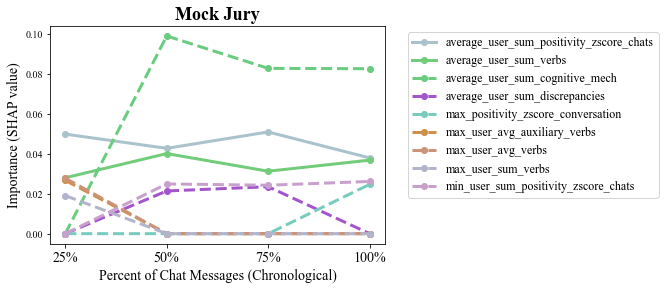

In [33]:
plot_important_features_over_time(merged_df, color_mapping, "Mock Jury", "./figures/jury_features_minchats.svg")

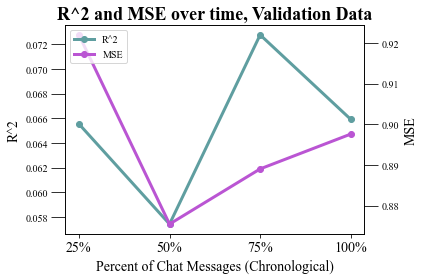

In [34]:
test_metrics = pd.concat([jury_test_means25, jury_test_means50, jury_test_means75, jury_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [35]:
# look at direction of impact
pd.concat([jury_shap_cor_means25, jury_shap_cor_means50, jury_shap_cor_means75, jury_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
average_user_sum_positivity_zscore_chats,0.663391,0.663985,0.664580,0.685833
average_user_sum_verbs,-0.750950,-0.732292,-0.690708,-0.690277
max_user_avg_verbs,-0.692680,-0.605763,NaN,NaN
max_user_avg_auxiliary_verbs,-0.769284,-0.405739,-0.398725,NaN
max_user_sum_verbs,-0.652799,-0.755049,-0.625153,-0.698149
average_indefinite_pronoun,-0.662495,-0.417671,NaN,-0.572390
stdev_user_avg_verbs,-0.626840,NaN,NaN,NaN
max_user_sum_auxiliary_verbs,-0.578447,-0.679783,-0.720718,-0.662353
stdev_past_tense,-0.669000,-0.590473,NaN,NaN


# CSOP (blended)

### Full Data (100%)

In [36]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"], min_num_chats=10)
csop_blended_model.select_target(target=["efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

In [37]:
csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics = repeated_kfold_cv(csop_blended_model)
csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means = get_repeated_kfold_cv_summary(csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 75% Data

In [38]:
csop_blended_model75 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_75/', min_num_chats=10)
csop_blended_model75.select_target(target=["efficiency", "efficiency"])
csop_blended_model75.define_model(model_type = 'rf')

In [39]:
csop_shap75, csop_shap_cor75, csop_train_metrics75, csop_test_metrics75 = repeated_kfold_cv(csop_blended_model75)
csop_shap_means75, csop_shap_cor_means75, csop_train_means75, csop_test_means75 = get_repeated_kfold_cv_summary(csop_shap75, csop_shap_cor75, csop_train_metrics75, csop_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [40]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/', min_num_chats=10)
csop_blended_model50.select_target(target=["efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'rf')

In [41]:
csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50 = repeated_kfold_cv(csop_blended_model50)
csop_shap_means50, csop_shap_cor_means50, csop_train_means50, csop_test_means50 = get_repeated_kfold_cv_summary(csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% Data

In [42]:
csop_blended_model25 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_25/', min_num_chats=10)
csop_blended_model25.select_target(target=["efficiency", "efficiency"])
csop_blended_model25.define_model(model_type = 'rf')

In [43]:
csop_shap25, csop_shap_cor25, csop_train_metrics25, csop_test_metrics25 = repeated_kfold_cv(csop_blended_model25)
csop_shap_means25, csop_shap_cor_means25, csop_train_means25, csop_test_means25 = get_repeated_kfold_cv_summary(csop_shap25, csop_shap_cor25, csop_train_metrics25, csop_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine CSOP Blended Data

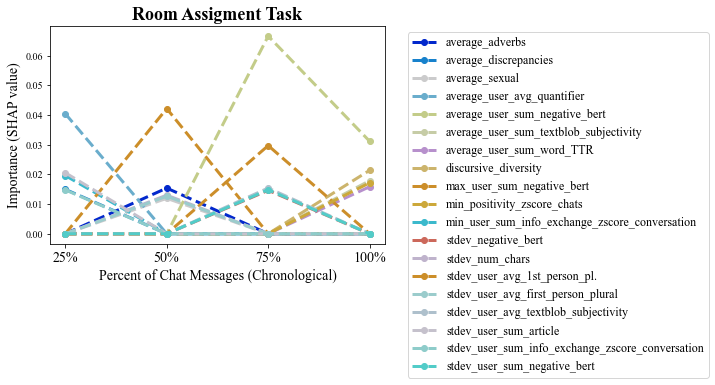

In [44]:
#csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means
merged_df = pd.concat([csop_shap_means25, csop_shap_means50, csop_shap_means75, csop_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, color_mapping, "Room Assigment Task", "./figures/csop_features_minchats.svg")

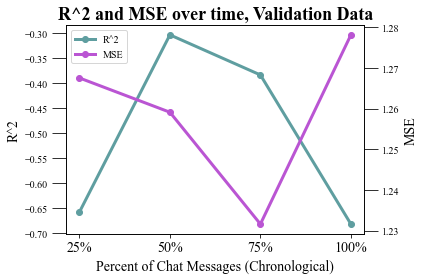

In [45]:
test_metrics = pd.concat([csop_test_means25, csop_test_means50, csop_test_means75, csop_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [46]:
# look at direction of impact
pd.concat([csop_shap_cor_means25, csop_shap_cor_means50, csop_shap_cor_means75, csop_shap_cor_means], keys = time_points, axis=1).head(20)

,25%,50%,75%,100%
feature,,,,
average_user_avg_quantifier,-0.756892,NaN,-0.407981,-0.590771
stdev_user_sum_article,0.390071,NaN,NaN,NaN
min_user_sum_info_exchange_zscore_conversation,0.634284,NaN,NaN,NaN
average_discrepancies,-0.691880,NaN,NaN,NaN
stdev_user_sum_info_exchange_zscore_conversation,-0.788136,NaN,NaN,NaN
stdev_discrepancies,-0.440611,NaN,NaN,NaN
average_user_avg_haspositive,0.712026,NaN,NaN,NaN
min_user_sum_positivity_zscore_chats,0.281290,NaN,NaN,0.057743
average_user_avg_num_question_naive,0.784265,NaN,NaN,NaN


In [47]:
pd.concat([csop_shap_means25, csop_shap_means50, csop_shap_means75, csop_shap_means], keys = time_points, axis=1).head(20)

,25%,50%,75%,100%
feature,,,,
average_user_avg_quantifier,0.040421,NaN,0.002867,0.007717
stdev_user_sum_article,0.020533,NaN,NaN,NaN
min_user_sum_info_exchange_zscore_conversation,0.019587,NaN,NaN,NaN
average_discrepancies,0.014935,NaN,NaN,NaN
stdev_user_sum_info_exchange_zscore_conversation,0.014758,NaN,NaN,NaN
stdev_discrepancies,0.012430,NaN,NaN,NaN
average_user_avg_haspositive,0.010668,NaN,NaN,NaN
min_user_sum_positivity_zscore_chats,0.009119,NaN,NaN,0.004670
average_user_avg_num_question_naive,0.008430,NaN,NaN,NaN


# DAT

### Full data (100%)

In [48]:
dat_model = ModelBuilder(dataset_names = ["dat"], min_num_chats=10)
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

In [49]:
dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics = repeated_kfold_cv(dat_model)
dat_shap_means, dat_shap_cor_means, dat_train_means, dat_test_means = get_repeated_kfold_cv_summary(dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 75% Data

In [50]:
dat_model75 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_75/', min_num_chats=10)
dat_model75.select_target(target=["efficiency"])
dat_model75.define_model(model_type = 'rf')

In [51]:
dat_shap75, dat_shap_cor75, dat_train_metrics75, dat_test_metrics75 = repeated_kfold_cv(dat_model75)
dat_shap_means75, dat_shap_cor_means75, dat_train_means75, dat_test_means75 = get_repeated_kfold_cv_summary(dat_shap75, dat_shap_cor75, dat_train_metrics75, dat_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [52]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/', min_num_chats=10)
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'rf')

In [53]:
dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50 = repeated_kfold_cv(dat_model50)
dat_shap_means50, dat_shap_cor_means50, dat_train_means50, dat_test_means50 = get_repeated_kfold_cv_summary(dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% Data

In [54]:
dat_model25 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_25/', min_num_chats=10)
dat_model25.select_target(target=["efficiency"])
dat_model25.define_model(model_type = 'rf')

In [55]:
dat_shap25, dat_shap_cor25, dat_train_metrics25, dat_test_metrics25 = repeated_kfold_cv(dat_model25)
dat_shap_means25, dat_shap_cor_means25, dat_train_means25, dat_test_means25 = get_repeated_kfold_cv_summary(dat_shap25, dat_shap_cor25, dat_train_metrics25, dat_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine DAT Results

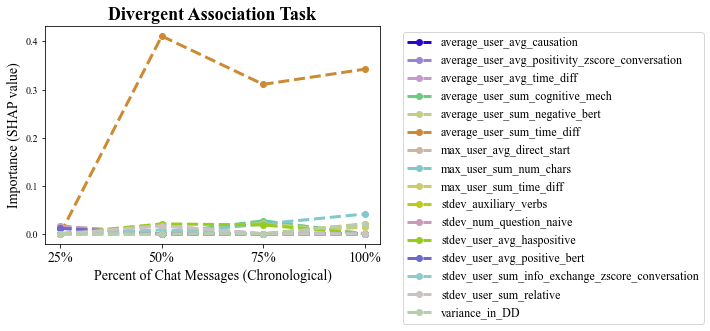

In [56]:
merged_df = pd.concat([dat_shap_means25, dat_shap_means50, dat_shap_means75, dat_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, color_mapping, "Divergent Association Task", "./figures/dat_features_minchats.svg")

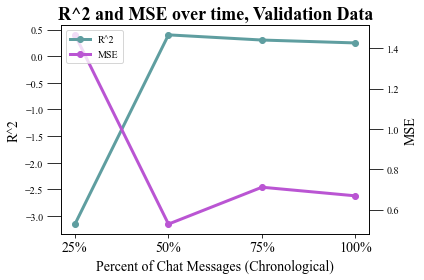

In [57]:
test_metrics = pd.concat([dat_test_means25, dat_test_means50, dat_test_means75, dat_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [58]:
# look at direction of impact
pd.concat([dat_shap_cor_means25, dat_shap_cor_means50, dat_shap_cor_means75, dat_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
max_user_avg_direct_start,0.790451,NaN,0.368857,0.443946
stdev_num_question_naive,-0.814901,-0.713171,NaN,-0.258008
average_user_avg_causation,0.262667,-0.125218,NaN,NaN
stdev_user_avg_positive_bert,0.741844,NaN,NaN,NaN
average_user_avg_positivity_zscore_conversation,0.166332,NaN,NaN,NaN
variance_in_DD,-0.150650,NaN,NaN,0.603928
average_num_question_naive,-0.568070,NaN,NaN,NaN
stdev_user_avg_positivity_zscore_chats,0.446691,NaN,NaN,NaN
max_user_avg_causation,0.291011,-0.229065,NaN,NaN


# Estimation

### Full Data (100%)

In [59]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"], min_num_chats=10)
estimation_blended_model.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

In [60]:
estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics = repeated_kfold_cv(estimation_blended_model)
estimation_shap_means, estimation_shap_cor_means, estimation_train_means, estimation_test_means = get_repeated_kfold_cv_summary(estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 75% Data

In [61]:
estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/', min_num_chats=10)
estimation_blended_model75.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model75.define_model(model_type = 'rf')

In [62]:
estimation_shap75, estimation_shap_cor75, estimation_train_metrics75, estimation_test_metrics75 = repeated_kfold_cv(estimation_blended_model75)
estimation_shap_means75, estimation_shap_cor_means75, estimation_train_means75, estimation_test_means75 = get_repeated_kfold_cv_summary(estimation_shap75, estimation_shap_cor75, estimation_train_metrics75, estimation_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 50% Data

In [63]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/', min_num_chats=10)
estimation_blended_model50.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'rf')

In [64]:
estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50 = repeated_kfold_cv(estimation_blended_model50)
estimation_shap_means50, estimation_shap_cor_means50, estimation_train_means50, estimation_test_means50 = get_repeated_kfold_cv_summary(estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### 25% Data

In [65]:
estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/', min_num_chats=10)
estimation_blended_model25.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model25.define_model(model_type = 'rf')

In [66]:
estimation_shap25, estimation_shap_cor25, estimation_train_metrics25, estimation_test_metrics25 = repeated_kfold_cv(estimation_blended_model25)
estimation_shap_means25, estimation_shap_cor_means25, estimation_train_means25, estimation_test_means25 = get_repeated_kfold_cv_summary(estimation_shap25, estimation_shap_cor25, estimation_train_metrics25, estimation_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Training Model...Done


### Combine Estimation Results

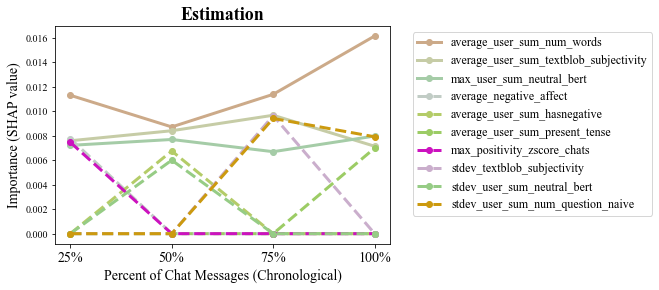

In [67]:
merged_df = pd.concat([estimation_shap_means25, estimation_shap_means50, estimation_shap_means75, estimation_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, color_mapping, "Estimation", "./figures/estimation_features_minchats.svg")

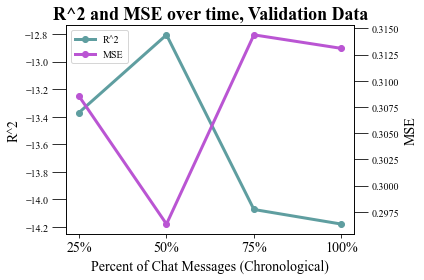

In [68]:
test_metrics = pd.concat([estimation_test_means25, estimation_test_means50, estimation_test_means75, estimation_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

In [69]:
# look at direction of impact
pd.concat([estimation_shap_cor_means25,estimation_shap_cor_means50, estimation_shap_cor_means75, estimation_shap_cor_means], keys = time_points, axis=1).head(10)

,25%,50%,75%,100%
feature,,,,
average_user_sum_num_words,-0.188346,-0.213160,-0.362511,-0.322801
average_negative_affect,-0.468045,-0.090968,0.000880,NaN
average_user_sum_textblob_subjectivity,-0.042238,-0.094594,-0.062975,-0.170133
max_positivity_zscore_chats,0.591013,NaN,NaN,NaN
max_user_sum_neutral_bert,-0.028973,0.061343,0.043561,-0.006996
average_user_sum_positive_bert,-0.191518,-0.349680,-0.138110,-0.024272
stdev_indefinite_pronoun,-0.328303,-0.318870,NaN,NaN
stdev_negative_affect,-0.306864,-0.003859,0.049773,NaN
max_positivity_zscore_conversation,0.648809,NaN,NaN,NaN


### Combine Metrics into Single Image

In [76]:
jury_metrics = pd.concat([jury_test_means25, jury_test_means50, jury_test_means75, jury_test_means], keys = time_points, axis=1) 
csop_metrics = pd.concat([csop_test_means25, csop_test_means50, csop_test_means75, csop_test_means], keys = time_points, axis=1)
dat_metrics = pd.concat([dat_test_means25, dat_test_means50, dat_test_means75, dat_test_means], keys = time_points, axis=1)
estimation_metrics = pd.concat([estimation_test_means25, estimation_test_means50, estimation_test_means75, estimation_test_means], keys = time_points, axis=1)

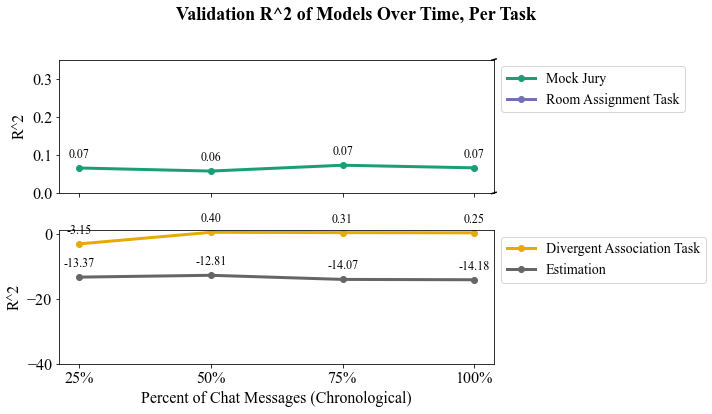

In [77]:
def plot_r2_with_broken_axis(datasets, dataset_names, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Define line styles and colors from Dark2 colormap
    num_colors = len(dataset_names)
    colors = mpl.cm.Dark2(np.linspace(0, 1, num_colors))

    # Plot positive datasets on ax1
    for i, dataset in enumerate([jury_metrics, csop_metrics]):
        dataset_name = dataset_names[i]
        transposed_data = dataset.T

        # Create the left y-axis for R^2 on the first plot
        ax1.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[i], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax1.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Set limits for ax1
    ax1.set_ylim(-0, 0.35)  # Adjust the limits as needed

    # Plot negative datasets on ax2
    for i, dataset in enumerate([dat_metrics, estimation_metrics]):
        j = i+2 #MESSY -- but this is manually set to the negative datasets (DAT, Estimation), and assumes they are the last 2 in the list
        dataset_name = dataset_names[j] 
        transposed_data = dataset.T

        # Create the left y-axis for R^2 on the first plot
        ax2.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[j], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Set limits for ax2
    ax2.set_ylim(-40, 1)  # Adjust the limits as needed

    # Remove the space between the two plots
    plt.subplots_adjust(hspace=0)

    # Adjust layout and labels
    ax1.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax2.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax1.set_ylabel("R^2", fontsize=16)
    ax2.set_ylabel("R^2", fontsize=16)
    ax2.set_xlabel("Percent of Chat Messages (Chronological)", fontsize=16)

    # Move the legend to the right
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1.005))  # Adjust the y-coordinate
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1.005))

    # Add broken y-axis symbol
    d = .005  # Offset for markings
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

    # Adjust title position to the top
    plt.suptitle(title, fontweight="bold", fontsize=18)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./figures/validation_test_r2_graph_minchats.svg', dpi=1200, bbox_inches='tight')
    plt.show()

datasets = [jury_metrics, csop_metrics, dat_metrics, estimation_metrics]
dataset_names = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]

plot_r2_with_broken_axis(datasets, dataset_names, "Validation R^2 of Models Over Time, Per Task")

In [72]:
jury_metrics = pd.concat([jury_train_means25, jury_train_means50, jury_train_means75, jury_train_means], keys = time_points, axis=1) 
csop_metrics = pd.concat([csop_train_means25, csop_train_means50, csop_train_means75, csop_train_means], keys = time_points, axis=1)
dat_metrics = pd.concat([dat_train_means25, dat_train_means50, dat_train_means75, dat_train_means], keys = time_points, axis=1)
estimation_metrics = pd.concat([estimation_train_means25, estimation_train_means50, estimation_train_means75, estimation_train_means], keys = time_points, axis=1)

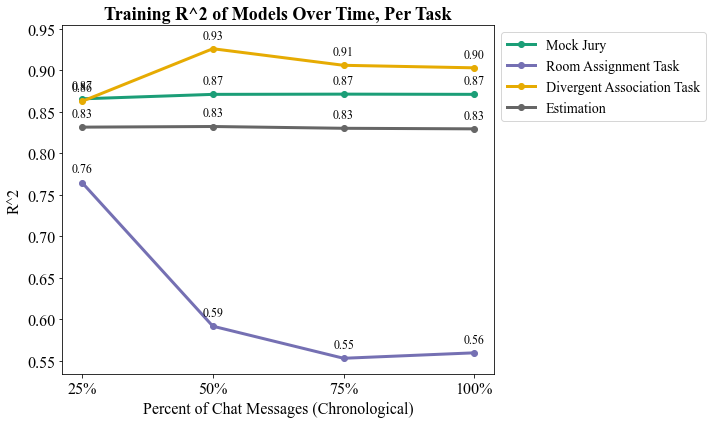

In [73]:
def plot_r2_without_broken_axis(datasets, dataset_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Define line styles and colors from Dark2 colormap
    num_colors = len(dataset_names)
    colors = mpl.cm.Dark2(np.linspace(0, 1, num_colors))

    # Plot datasets on the same y-axis
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[i]
        transposed_data = dataset.T

        # Plot R^2 values for each dataset
        ax.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[i], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Adjust layout and labels
    ax.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax.set_ylabel("R^2", fontsize=16)
    ax.set_xlabel("Percent of Chat Messages (Chronological)", fontsize=16)

    # Add legend to the right
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1))

    # Set y-axis range with a buffer
    ax.set_ylim(min(ax.get_ylim()), max(ax.get_ylim())*1.01)

    # Adjust title position
    plt.title(title, fontweight="bold", fontsize=18)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('./figures/train_r2_graph_minchats.svg', dpi=1200, bbox_inches='tight')
    plt.show()

# Assuming you have defined the four datasets and their names as you described
datasets = [jury_metrics, csop_metrics, dat_metrics, estimation_metrics]
dataset_names = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]

# Call the function to plot R^2 values without broken y-axis
plot_r2_without_broken_axis(datasets, dataset_names, "Training R^2 of Models Over Time, Per Task")
